# Part 2: Preprocessing intracranial EEG using MNE-python - Epochs!

*WIRED 2024*  
[Maansi Desai, PhD](https://maansidesai.github.io/)  
Postdoctoral Researcher in the [Hamilton Lab](https://slhs.utexas.edu/research/hamilton-lab)
<br>
Department of Speech, Language, and Hearing Sciences 
<br>
The University of Texas at Austin  

This is part two of the notebooks. Please first run through [`01_ieeg_preprocessing_MNE.ipynb`](01_ieeg_preprocessing_MNE.ipynb) before running this. In this portion of the tutorial, you will learn about epoching your data. Epoched data allows you to calculate averaged responses to events of interest (event-related potentials). We will do this based on the provided annotations of speech vs. music, as well as additional annotations that are available in the Berezutskaya dataset.

In [216]:
import mne
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import os
from mne_bids import read_raw_bids, print_dir_tree
from mne_bids.path import get_bids_path_from_fname
from bids import BIDSLayout
from ecog_preproc_utils import transformData
import bids 

print(mne.__version__)

1.6.1


## Load BIDS iEEG dataset


Here we will download an example iEEG dataset from [this dataset from the Hamilton lab](https://openneuro.org/datasets/ds004993/versions/1.1.1). If you have ran [`01_ieeg_preprocessing_MNE`](01_ieeg_preprocessing_MNE), then you should already have downloaded the necessary datasets locally. 

For this notebook we will use data from: 
 - `sub-W2`, `iemu`, `B8`, `timit5`

In [ ]:
# This is the example participant's data that we will load for the tutorial,
# but there are more options.

# In this example, we will be loading data from subj W2 to plot evoked responses to sentences from the TIMIT speech corpora.
subj = 'W2'
sess = 'iemu'
task = 'timit5'
acq = 'B8'
run = '01'

parent_dir = 'data/ds004993' # This is on the jupyter hub

In [7]:
# Change the data directory below to where your data are located. 

# ieeg_dir = f'{parent_dir}/sub-{subj}/ses-{sess}/ieeg/'
# channel_path = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_channels.tsv'
# raw_path = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_ieeg.vhdr'

# bids_path = get_bids_path_from_fname(raw_path)
# base_name = os.path.basename(raw_path).split('.')[0]

ieeg_dir = f'{parent_dir}/sub-{subj}/ses-{sess}/ieeg/'
channel_path = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_channels.tsv'
raw_path = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_ieeg.edf'


bids_path = get_bids_path_from_fname(raw_path)
base_name = os.path.basename(raw_path).split('.')[0]

print(bids_path)


data/ds004993/sub-W2/ses-iemu/ieeg/sub-W2_ses-iemu_task-timit5_acq-B8_run-01_ieeg.edf


## Load the iEEG data

First, we will choose the relevant subject, session, task, acquisition, and run. Note that if you wish to change these variables, you may need to download the data yourself.

To show the capabilities of BIDS and contrast to when we don't use BIDS, we'll load the data in two ways. The data structure using BIDS will be called `raw`, the data structure without BIDS will be `raw_nobids`.

In [135]:
# Read data and extract parameters from BIDS files
raw = read_raw_bids(bids_path, verbose=True)

raw_edf = mne.io.read_raw_edf(raw_path, preload=True) 


Extracting EDF parameters from /Users/maansidesai/Desktop/git/WIRED-2024-Paris/notebooks/data/ds004993/sub-W2/ses-iemu/ieeg/sub-W2_ses-iemu_task-timit5_acq-B8_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from data/ds004993/sub-W2/ses-iemu/ieeg/sub-W2_ses-iemu_task-timit5_acq-B8_run-01_events.tsv.
Reading channel info from data/ds004993/sub-W2/ses-iemu/ieeg/sub-W2_ses-iemu_task-timit5_acq-B8_run-01_channels.tsv.
Reading electrode coords from data/ds004993/sub-W2/ses-iemu/ieeg/sub-W2_ses-iemu_task-timit5_acq-B8_run-01_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Extracting EDF parameters from /Users/maansidesai/Desktop/git/WIRED-2024-Paris/notebooks/data/ds004993/sub-W2/ses-iemu/ieeg/sub-W2_ses-iemu_task-timit5_acq-B8_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 182783  =      0.000 ...   356.998 secs...


/var/folders/03/nrm13jr11b734k78bp62stg80000gq/T/ipykernel_8300/4210343176.py:2: RuntimeWarning: Omitted 102 annotation(s) that were outside data range.
  raw = read_raw_bids(bids_path, verbose=True)
/var/folders/03/nrm13jr11b734k78bp62stg80000gq/T/ipykernel_8300/4210343176.py:4: RuntimeWarning: Omitted 102 annotation(s) that were outside data range.
  raw_edf = mne.io.read_raw_edf(raw_path, preload=True)


In [56]:
# Let's load the data into memory and print some information about it. The 
# info structure contains a lot of helpful metadata about number of channels,
# sampling rate, data types, etc. It can also contain information about the
# participant and date of acquisition, however, this dataset has been anonymized.
raw.load_data()
raw.info

Reading 0 ... 182783  =      0.000 ...   356.998 secs...


Measurement date,"January 01, 2024 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-W2
Digitized points,106 points
Good channels,106 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


In [137]:
raw_edf.info

Measurement date,"January 01, 2024 00:00:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,106 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


# Calculate the high gamma transform of your data

Now we will take the raw, preprocessed data, and convert to high gamma analytic amplitude for further analysis. The high gamma analytic amplitude is used in many papers as a proxy for multi-unit firing (see [Ray and Maunsell, PLoS Biology 2011](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000610)).

This particular version of the high gamma transform uses the same procedure as used in [Hamilton et al. 2018](cell.com/current-biology/pdf/S0960-9822(18)30461-5.pdf) and [Hamilton et al. 2021](https://www.cell.com/cell/pdf/S0092-8674(21)00878-3.pdf). The basic idea is to take 8 bands within the 70-150 Hz range, calculate the Hilbert transform, then take the analytic amplitude of that signal and average across the 8 bands. This form of averaging results in higher SNR than one band between 70-150 Hz. 

In [138]:
# Get only the iEEG channels for high gamma
raw_ieeg = raw.copy()
raw_ieeg.pick_types(seeg=True)
raw_ieeg.anonymize()

notch_freqs = list(np.arange(raw.info['line_freq'], raw.info['lowpass'], step=raw.info['line_freq']))
# Get the high gamma data
# Generally, do a CAR if you have widespread coverage over multiple
# areas (not just one sensory area)
# If you have limited coverage, you may choose to do no CAR or choose
# to reference to one specific channel.
hgdat = transformData(raw_edf, ieeg_dir, band='high_gamma', notch=True, CAR=True,
                      car_chans='average', log_transform=True, do_zscore=True,
                      hg_fs=100, notch_freqs=notch_freqs, ch_types='seeg')


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Doing notch filter
Effective window size : 4.000 (s)
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



/Users/maansidesai/Desktop/git/WIRED-2024-Paris/notebooks/ecog_preproc_utils.py:79: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot(picks='data', exclude=[])
/Users/maansidesai/Applications/MNE-Python/1.6.1_0/.mne-python/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Effective window size : 4.000 (s)


/Users/maansidesai/Desktop/git/WIRED-2024-Paris/notebooks/ecog_preproc_utils.py:81: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot(picks='data', exclude=[])
/Users/maansidesai/Applications/MNE-Python/1.6.1_0/.mne-python/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Using pyopengl with version 3.1.6
Channels marked as bad:
none
Doing CAR on
average
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using pyopengl with version 3.1.6
Channels marked as bad:
none
Getting frequency bands for Hilbert transform
Getting high_gamma band data
Getting the raw data array


applying Hilbert transform...:   0%|                      | 0/8 [00:00<?, ?it/s]/Users/maansidesai/Desktop/git/WIRED-2024-Paris/notebooks/ecog_preproc_utils.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  hilbdat[ch,:] = applyHilbertTransform(raw_data[ch,:], raw.info['sfreq'], ct, sd)


Taking log transform of high gamma


applying Hilbert transform...:  12%|█▊            | 1/8 [00:02<00:16,  2.37s/it]

Taking log transform of high gamma


applying Hilbert transform...:  25%|███▌          | 2/8 [00:04<00:13,  2.33s/it]

Taking log transform of high gamma


applying Hilbert transform...:  38%|█████▎        | 3/8 [00:06<00:11,  2.32s/it]

Taking log transform of high gamma


applying Hilbert transform...:  50%|███████       | 4/8 [00:09<00:09,  2.35s/it]

Taking log transform of high gamma


applying Hilbert transform...:  62%|████████▊     | 5/8 [00:11<00:06,  2.25s/it]

Taking log transform of high gamma


applying Hilbert transform...:  75%|██████████▌   | 6/8 [00:13<00:04,  2.21s/it]

Taking log transform of high gamma


applying Hilbert transform...:  88%|████████████▎ | 7/8 [00:15<00:02,  2.16s/it]

Taking log transform of high gamma


applying Hilbert transform...: 100%|██████████████| 8/8 [00:17<00:00,  2.22s/it]


Taking the mean across 8 bands
Z-scoring signal
Creating RawArray with float64 data, n_channels=106, n_times=182784
    Range : 0 ... 182783 =      0.000 ...   356.998 secs
Ready.
Saving to data/ds004993/sub-W2/ses-iemu/ieeg/HilbAA_70to150_8band/ecog_hilbAA_70to150_8band_notch_car_log.fif
Using pyopengl with version 3.1.6
Channels marked as bad:
none


# Plotting evoked data

Now that we have some preprocessed data, let's plot the differences between experimental conditions. To do this, we will need the events timings, which are included in the `events.tsv` file. In this case, the events correspond to blocks of music and speech.

## Loading events

Now we will load events from the .tsv file to plot evoked responses to music and speech events. First I'll show you how to do this by creating an MNE events array, next I'll show you how to derive them from the annotations. This first method could also be used with non-BIDS datasets if you have the onset and duration and trial information.

In [140]:
# This is a simple way of loading a tab-delimited file, and is not specific to
# MNE python. We're using the library pandas, which you may also find very
# helpful in other applications.
event_file = f'{ieeg_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-01_events.tsv'
event_df = pd.read_csv(event_file, delimiter='\t')



In [141]:
# Let's print the contents of this dataframe. 
event_df

,onset,duration,trial_type,value,sample
0,18.152344,1.001000,TIMIT_tone,1,9294
1,20.181641,1.369625,fcaj0_si1479,2,10333
2,22.619141,1.600000,fdfb0_si1948,4,11581
3,25.289062,1.766437,fisb0_si2209,6,12948
4,28.146484,1.926437,mbbr0_si2315,8,14411
...,...,...,...,...,...
97,281.474609,1.766437,fisb0_si2209,6,144115
98,284.330078,2.355250,mjmm0_si625,12,145577
99,287.767578,1.504000,mdlc2_si2244,9,147337
100,290.343750,1.798437,fcaj0_si1804,3,148656


## Convert event times to samples

Now these event times are in seconds, not samples, so we have to convert them for use with MNE python's epochs constructor. Let's do that here. 

The times here are in seconds, and sampling rate is in units of Hz (samples/sec), so to get samples, we just multiply the amount of time by the sampling rate.

\begin{eqnarray}
\mbox{number of samples} &=& \mbox{time }  \times \mbox{sampling rate}\\
\mbox{(samples)} &=& \mbox{(s) }  \times \mbox{(samples/sec)}
\end{eqnarray}

We also cast these as integers since data samples are discrete values.

In [169]:
np.vstack((onset_samp, dur_samp, ev_id)).T

array([[ 1815,   100,     1],
       [ 2018,   136,     2],
       [ 2261,   159,     4],
       [ 2528,   176,     6],
       [ 2814,   192,     8],
       [ 3114,   150,     9],
       [ 3371,   179,     3],
       [ 3659,   152,    10],
       [ 3919,   133,    11],
       [ 4161,   235,    12],
       [ 4505,   179,     3],
       [ 4792,   136,     2],
       [ 5036,   133,    11],
       [ 5278,   152,    10],
       [ 5538,   136,     5],
       [ 5782,   192,     8],
       [ 6081,   150,     9],
       [ 6339,   159,     4],
       [ 6606,   235,    12],
       [ 6950,   176,     6],
       [ 7235,   179,     3],
       [ 7523,   152,    10],
       [ 7783,   159,     4],
       [ 8050,   150,     9],
       [ 8308,   136,     2],
       [ 8552,   179,     3],
       [ 8840,   133,    11],
       [ 9081,   176,     6],
       [ 9367,   136,     5],
       [ 9611,   192,     8],
       [ 9910,   133,    11],
       [10152,   160,     4],
       [10419,   152,    10],
       [10

In [209]:
onset_samp = [int(onset*hgdat.info['sfreq']) for onset in event_df.onset]
dur_samp = [int(dur*hgdat.info['sfreq']) for dur in event_df.duration]
ev_id = [int(e) for e in event_df.value]


#eve = list(zip(onset_samp, dur_samp, ev_id))
eve = np.vstack((onset_samp, dur_samp, ev_id)).T
eve

array([[ 1815,   100,     1],
       [ 2018,   136,     2],
       [ 2261,   159,     4],
       [ 2528,   176,     6],
       [ 2814,   192,     8],
       [ 3114,   150,     9],
       [ 3371,   179,     3],
       [ 3659,   152,    10],
       [ 3919,   133,    11],
       [ 4161,   235,    12],
       [ 4505,   179,     3],
       [ 4792,   136,     2],
       [ 5036,   133,    11],
       [ 5278,   152,    10],
       [ 5538,   136,     5],
       [ 5782,   192,     8],
       [ 6081,   150,     9],
       [ 6339,   159,     4],
       [ 6606,   235,    12],
       [ 6950,   176,     6],
       [ 7235,   179,     3],
       [ 7523,   152,    10],
       [ 7783,   159,     4],
       [ 8050,   150,     9],
       [ 8308,   136,     2],
       [ 8552,   179,     3],
       [ 8840,   133,    11],
       [ 9081,   176,     6],
       [ 9367,   136,     5],
       [ 9611,   192,     8],
       [ 9910,   133,    11],
       [10152,   160,     4],
       [10419,   152,    10],
       [10

## Another way...

So actually, because we already had these particular events as annotations, we could have also done this a simpler way, but the method above also works for other events that are stored in tsv files without becoming annotations.

In [91]:
hgdat.plot()


Using pyopengl with version 3.1.6


In [147]:
# We could also do this with the `raw` object
#events = mne.events_from_annotations(hgdat, event_id='auto')

#you can load event_ids from the BIDS data which stored all of the markers which is in a sampling rate of 512 Hz...because getting high gamma 
#from BIDS didn't work as expected...
events = mne.events_from_annotations(raw_ieeg, event_id='auto')

Used Annotations descriptions: ['TIMIT_tone', 'fcaj0_si1479', 'fcaj0_si1804', 'fdfb0_si1948', 'fdxw0_si2141', 'fisb0_si2209', 'ftbw0_si1345', 'mbbr0_si2315', 'mdlc2_si2244', 'mdls0_si998', 'mjdh0_si1984', 'mjmm0_si625']


## Create an epochs object

Now if we want to plot our data by epoch type, we can use the mne Epochs class. This allows us to parse our data according to these events and plot evoked activity.

In [210]:
tmin = -0.2  # How much time to account for before the event of interest
tmax = 0.5   # How much time to account for after the event of interest

events = eve
#event_id = events[1]  # This is the speech event ID
event_id = events[:,2][1]

# Here we take events[0] because those are the timings, whereas events[1] has
# the information about event type. If you just have a list of timings,
# you don't need to index the events in this way.
epochs = mne.Epochs(hgdat, events=events, tmin=tmin, tmax=tmax, event_id=event_id) 

Not setting metadata
10 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


Using data from preloaded Raw for 10 events and 71 original time points ...
0 bad epochs dropped
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


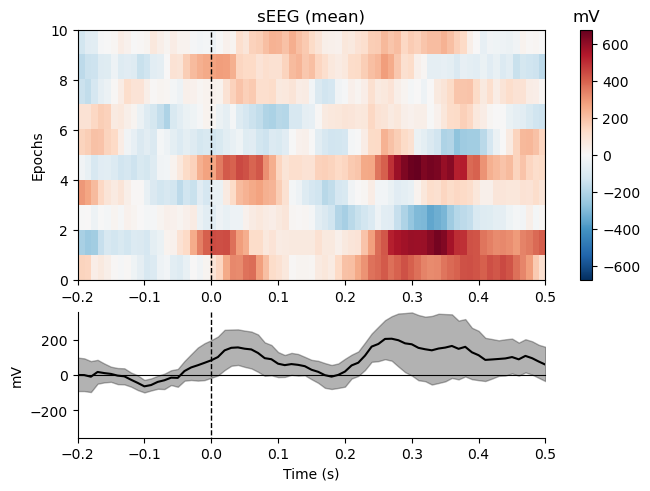

[<Figure size 640x480 with 3 Axes>]

In [211]:
# Here we will just plot the average across all channels. This is a bit
# weird to do with iEEG because this is across a lot of different brain
# areas, but it's still possible.
epochs.plot_image(combine='mean')

plotting channel for RPPST12
Using data from preloaded Raw for 10 events and 71 original time points ...
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


/var/folders/03/nrm13jr11b734k78bp62stg80000gq/T/ipykernel_8300/2739106986.py:5: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=[hgdat.info['ch_names'][49]])


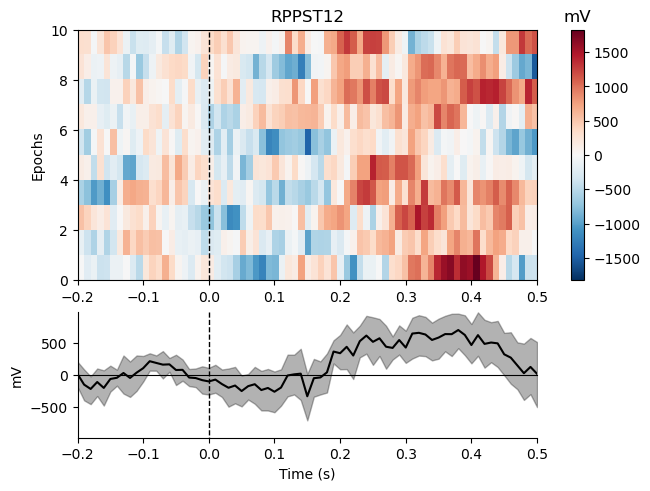

[<Figure size 640x480 with 3 Axes>]

In [215]:
# What about plotting a particular electrode? This is one that
# appears to be on the STG based on the image above
ch_name = hgdat.info['ch_names'][49]
print(f'plotting channel for {ch_name}')
epochs.plot_image(picks=[hgdat.info['ch_names'][49]])

In [180]:
def plot_epochs(epochs, nchans, ch_names, color='b', label='spkr', show=True, vmin_max=None):
    '''
    Function that plots the averaged epoched data for each channel as a grid so you can 
    see all channels at once.
    
    Inputs:
        epochs [obj] : MNE epochs object
        nchans [int] : number of channels to plot
        ch_names [list] : channel names 
        color [str, hex, tuple]: color for ERP traces
        label [str] : label for the ERP (could be epoch type/annotation type) 
        show [bool] : whether to show the figure or not
        vmin_max [list] : list of ylim min and max, e.g. [-0.5, 0.5]
        
    '''
    
    # Get the data as an array
    eps = epochs.get_data()
    
    # Find the maximum across the whole dataset, helps with scaling the plots
    emax = np.abs(epochs.average().data).max()
    
    # Determine how many rows and columns we'll need in our subplots grid
    # based on the number of channels. 
    nrows = int(np.floor(np.sqrt(nchans)))
    ncols = int(np.ceil(nchans/nrows))
    
    # Loop through all electrode channels
    for ch in np.arange(nchans):
        plt.subplot(nrows, ncols, ch+1)
        
        # Get the average response across trials for this particular channel
        erp = eps[:,ch,:].mean(0)
        
        # Get the standard error across trials
        erpstderr = eps[:,ch,:].std(0)/np.sqrt(eps.shape[0])
        
        # Plot transparent shaded standard error in the [color] you choose
        ybottom = erp - erpstderr
        ytop = erp + erpstderr
        plt.fill_between(epochs.times, ybottom.ravel(), ytop.ravel(),
                         alpha=0.5, color=color)
        
        # Plot the average epoch on top in the same color
        plt.plot(epochs.times, erp, color=color, label=label)
        
        # Plot the x and y origins
        plt.axvline([0], color='k', linewidth=0.5)
        plt.axhline([0], color='k', linewidth=0.5)
        
        # If we haven't explicitly set ylimits with vmin/vmax, use 
        # the maximum of the data and 50% more so the whole thing 
        # fits nicely 
        if vmin_max is None:
            plt.gca().set_ylim([-emax*1.5, emax*1.5])
        else:
            plt.gca().set_ylim([vmin_max[0], vmin_max[1]])
            
        # Only show the ticks for the 0th plot, otherwise this gets
        # hard to see/read
        if ch != 0:
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        else:
            plt.ylabel('Z-score')
        
        # Write the name of the channel in the plot -- you could also
        # use plt.title() but sometimes that makes everything look
        # a little squashed
        plt.text(0.5, 0.25, ch_names[ch], 
            horizontalalignment='center', verticalalignment='center',
            transform=plt.gca().transAxes, fontsize=8)
    
    # Plot ticks at meaningful times (the min, 0, and max in seconds)
    plt.gca().set_xticks([epochs.tmin, 0, epochs.tmax])
    plt.xlabel('Time (s)')
    plt.legend()
    #plt.tight_layout()
    if show:
        plt.show()

Using data from preloaded Raw for 10 events and 71 original time points ...


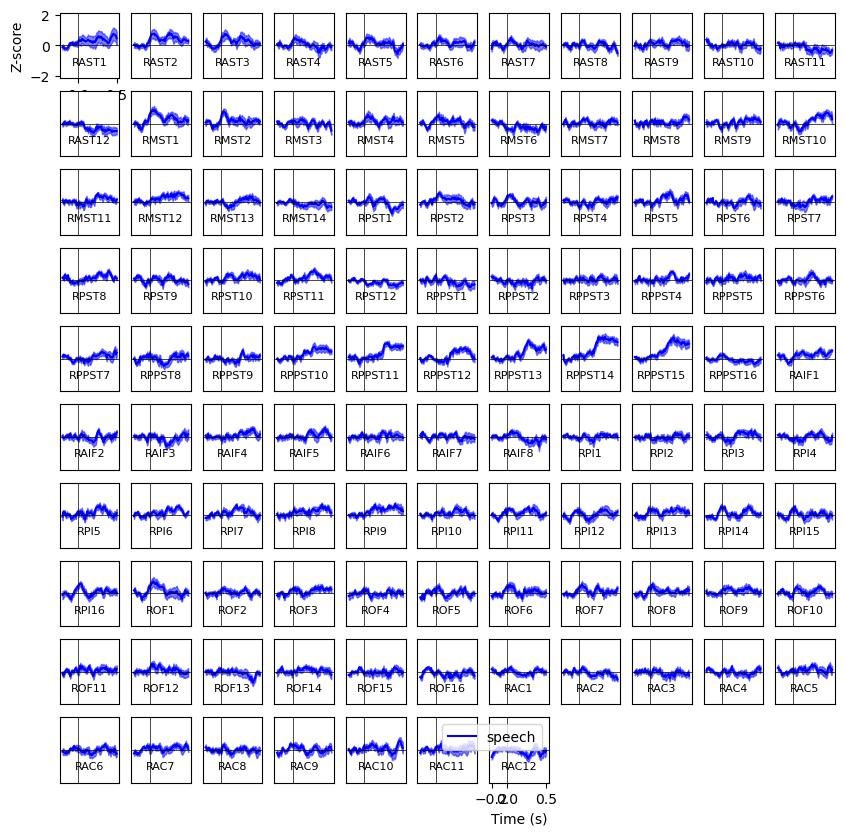

In [181]:
plt.figure(figsize=(10,10))
plot_epochs(epochs, len(hgdat.info['ch_names']), hgdat.info['ch_names'], label='speech', show=True)

# Now let's try epoching based on phoneme information. Work together by yourself or with your neighbor. 

### Make sure you have followed the instruction on the [github repo](https://github.com/maansidesai/WIRED-2024-Paris?tab=readme-ov-file) to download the [Berezutskaya iEEG and fMRI data from movie viewing](https://openneuro.org/datasets/ds003688/versions/1.0.7) dataset for `sub-06`. 

There are many other subjects in this BIDS dataset that you can eventually use for your own analysis or visualization. However for the purpose of this exercise, we have request you all to download `sub-06` due to the large size of the complete Berezutskaya et al. dataset.


Open [`04_ieeg_breakout_MNE.ipynb`](04_ieeg_breakout_MNE.ipynb)

### Create the new word events epochs (We're going to change this to phoneme information for students to work on as an exercise during the tutorial)

In [ ]:
word_events = []

# Loop through the times for each word event and convert to samples, as we did before
# This time we can't use annotations, because these word events were not included
# as annotations in the raw files, just as .tsv files.
for idx, row in word_times.iterrows():
    onset_sample = int(row['onset']*hgdat.info['sfreq'])  # convert time to samples
    offset_sample = int(row['offset']*hgdat.info['sfreq'])  # convert time to samples
    duration_sample = offset_sample - onset_sample  # Get the duration in samples
    onset_sample += start_sample  # need to shift by the actual starting time of the task
    
    # Append this event to our events list
    word_events.append([onset_sample, duration_sample, 1])


In [ ]:
# Now create the epochs object again. Note that we don't need to index the `word_events`
# because it is already a list in the correct format
epochs_words = mne.Epochs(hgdat, events=word_events, tmin=-0.2, tmax=0.5)

### Plot word epochs!

In [ ]:
# Plot the average across all channels
epochs_words.plot_image(combine='mean')

In [ ]:
# Plot one subplot for each channel as we had done before
plot_epochs(epochs_words, len(hgdat.info['ch_names']), hgdat.info['ch_names'], label='words')

In [ ]:
# Plot one example electrode that has a strong word response
epochs_words.plot_image(picks=['P18'])

### Export data to numpy array

If we want to export the data to use with our own functions, we can also do that with the `.get_data()` method.

In [ ]:
# Get the data from our epochs_words object to do other things with
epochs_array = epochs_words.get_data()
print(f'{epochs_array.shape[0]} {annotation} events for\
  {epochs_array.shape[1]} channels and {epochs_array.shape[2]} time points')

In [ ]:
# Use matplotlib to show the average across all epochs
# Scale to the -max(abs) of the data and max(abs) of the data
# with a diverging colormap so that the color for 0 is white,
# and positive values are red, and negative values are blue
plt.imshow(epochs_array.mean(0), cmap=cm.RdBu_r, 
           vmin=-np.max(np.abs(epochs_array.mean(0))),
           vmax=np.max(np.abs(epochs_array.mean(0))))  # Take the average across all trials (words)
plt.xlabel('Time')
plt.ylabel('Channel')
plt.gca().set_xticks([0, 
                      -int(epochs_words.tmin*epochs_words.info['sfreq']), 
                      int((epochs_words.tmax - epochs_words.tmin)*epochs_words.info['sfreq'])])
plt.gca().set_xticklabels([epochs_words.tmin, 0, epochs_words.tmax])
plt.axvline(-int(epochs_words.tmin*epochs_words.info['sfreq']), color='k', linestyle='--')
plt.colorbar()
plt.show()

# That's it!

Some suggestions for things you can try:

* Create epochs for different types of events - speech, music, syllables, sentences, etc
* Compare amplitude of speech versus music responses in each electrode. Note that you can use `show=False` and call `plot_epochs` more than once to plot different epochs on the same axes
* Look at effects of referencing on the evoked data/epochs.